# Derivatives in Theano

Following:

http://deeplearning.net/software/theano/tutorial/gradients.html

## Computing gradients

Let's create a function which computes the derivative of some expression `y` w.r.t. `x`. We will use the macro `T.grad`.

In [1]:
import theano
import theano.tensor as T
from theano import pp

In [2]:
x = T.dscalar('x')
y = x ** 2
gy = T.grad(y, x)
pp(gy)

'((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

In [3]:
f = theano.function([x], gy)

In [4]:
f(4)

array(8.0)

In [5]:
f(94.2)

array(188.4)

**Note**: we can't `pp(f)` - functions have no `.owner`.

**Note**: The optimizer simplifies the gradient expression:

In [6]:
pp(f.maker.fgraph.outputs[0])

'(TensorConstant{2.0} * x)'

In [7]:
type(f)

theano.compile.function_module.Function

In [8]:
import numpy as np

In [11]:
xx = np.linspace(0, 1, 10)
yy = [f(x0) for x0 in xx]

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

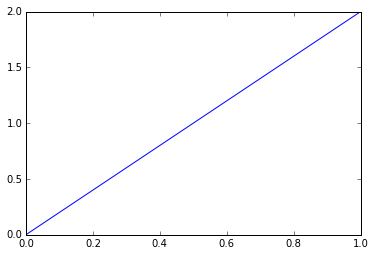

In [13]:
plt.plot(xx, yy)

We can also compute the gradient of complex expressions such as the logistic function. It turns out that:
\begin{equation}
\frac{ds}{dx} = s(x) \cdot (1 - s(x))
\end{equation}

In [14]:
x = T.dmatrix('x')
s = T.sum(1 / (1 + T.exp(-x)))
gs = T.grad(s, x)
dlogistic = theano.function([x], gs)

In [15]:
dlogistic([[0, 1], [-1, -2]])

array([[ 0.25      ,  0.19661193],
       [ 0.19661193,  0.10499359]])

In general, for any **scalar** expression `s`, `T.grad(s, w)` provides the Theano expression for computing $\frac{\partial s}{\partial w}$.

**Note**: The second argument of `T.grad` can be a list, in which case the output is also a list. For example:

    gw, gb = T.grad(cost, [w, b])

## Computing the Jacobian

In Theano's parlance, the _Jacobian_ is the tensor comprising the first partial derivatives of the output of a function with respect to its inputs. (This is a generalization of the Jacobian matrix.) The `theano.gradient.jacobian()` macro does everything needed to compute the Jacobian. But, we can also do it "by hand"...

To manually compute the Jacobian we need to use `scan` and loop over the entries in our function `y` and compute the gradient with respect to `x`.

**Note**: `scan` is a generic op in Theano that allows writing in a symbolic manner all kinds of recurrent equations.

In [16]:
x = T.dvector('x')
y = x ** 2
J, updates = theano.scan(lambda i, y, x: T.grad(y[i], x), sequences=T.arange(y.shape[0]), non_sequences=[y, x])
f = theano.function([x], J, updates=updates)

/Users/perdue/anaconda/envs/python2/lib/python2.7/site-packages/theano/gof/cmodule.py:293: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  rval = __import__(module_name, {}, {}, [module_name])


In [17]:
f([4, 4])

array([[ 8.,  0.],
       [ 0.,  8.]])

This code generates a sequence of _ints_ from 0 to `y.shape[0]` using `T.arange`. Then we loop through the sequence and at each step we compute the gradient of element `y[i]` with respect to `x`. `scan` concatenates all these rows, generating a maxtrix that corresponds to the Jacobian.

In [22]:
np.array([4, 4]).shape

(2,)

In [23]:
np.array([4, 4]).shape[0]

2

In [24]:
np.arange(np.array([4, 4]).shape[0])

array([0, 1])

In [25]:
a = np.array([4, 4])
b = a ** 2

So here, `T.arange(y.shape[0])` ultimately is `[0, 1]`. The gradient is just `2x`, and the off-diagonals are zero because we are differentiating w.r.t. `x_1` and then `x_2`, but there are no cross terms?

In [29]:
f([4, 4, 4, 4])

array([[ 8.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.],
       [ 0.,  0.,  8.,  0.],
       [ 0.,  0.,  0.,  8.]])

In [30]:
theano.gradient.jacobian(y, x)

for{cpu,scan_fn}.0

In [35]:
jj = theano.gradient.jacobian(y, x)

In [36]:
fj = theano.function([x], jj)

In [37]:
fj([4, 4])

array([[ 8.,  0.],
       [ 0.,  8.]])

In [54]:
x = T.dvector('x')
y = T.dvector('y')
z = x ** 2 + y ** 2 + 2 * x * y
jz = theano.gradient.jacobian(z, [x, y])

In [55]:
fjz = theano.function([x, y], jz)

In [56]:
fjz([1, 2, 3], [4, 5, 6])

[array([[ 10.,   0.,   0.],
        [  0.,  14.,   0.],
        [  0.,   0.,  18.]]), array([[ 10.,   0.,   0.],
        [  0.,  14.,   0.],
        [  0.,   0.,  18.]])]

In [57]:
fjz([1, 2], [3, 4])

[array([[  8.,   0.],
        [  0.,  12.]]), array([[  8.,   0.],
        [  0.,  12.]])]

In [60]:
fjz([2, 2], [2, 2])

[array([[ 8.,  0.],
        [ 0.,  8.]]), array([[ 8.,  0.],
        [ 0.,  8.]])]

In [62]:
x = T.dmatrix('x')
y = T.dmatrix('y')
z = T.flatten(x ** 2 * y ** 2)
jz = theano.gradient.jacobian(z, [x, y])

In [66]:
fjz([2, 2], [2, 2])

[array([[ 8.,  0.],
        [ 0.,  8.]]), array([[ 8.,  0.],
        [ 0.,  8.]])]

## Computing the Hessian

In Theano, the _Hessian_ has the usual mathematical meaning: it is the matrix comprising the second order partial derivative of a function with scalar output and vector input. `theano.gradient.hessian()` does all that is needed to compute the Hessian, but we may also do it manually.

The manual computation of the Hessian is similar to that of the Jacobian. The difference now is that, instead of computing the Jacobian of some expression `y`, we compute the Jacobian of `T.grad(cost, x)` where `cost` is a scalar.

In [67]:
x = T.dvector('x')
y = x ** 2
cost = y.sum()
gy = T.grad(cost, x)
H, updates = theano.scan(lambda i, gy, x: T.grad(gy[i], x), sequences=T.arange(gy.shape[0]), non_sequences=[gy, x])
f = theano.function([x], H, updates=updates)

In [68]:
f([4, 2])

array([[ 2.,  0.],
       [ 0.,  2.]])

**Note**: Recall that in maximum likelihood estimation, solving the equation where we set the gradient of the likelihood function equal to zero (the so-called "estimating equation") provides estimates of the coefficients of the model. The negative of the inverse of the Hessian matrix produces the estimated variance-covariance matrix of the parameter estimates of the model.

## Jacobian times a vector

Sometimes we can express algorithms in terms of Jacobians times vectors or vectors times Jacobians. In these cases, it is sometimes faster to evaluate the composite than it is to find the Jacobian first and then multiply. We would like Theano to identify these patterns for us, but this is a difficult general problem. Therefore, there are special functions for this task.

### R-operator

The _R operator_ is built to evaluate the product between a Jacobian and a vector, $ \frac{\partial f(x)}{\partial x} v$.

In [69]:
W = T.dmatrix('W')
V = T.dmatrix('V')
x = T.dvector('x')
y = T.dot(x, W)
JV = T.Rop(y, W, V)
f = theano.function([W, V, x], JV)

In [70]:
W_1 = [[1, 1], [1, 1]]
V_1 = [[2, 2], [2, 2]]
x_1 = [0, 1]
f(W_1, V_1, x_1)

array([ 2.,  2.])

### L-operator

The _L operator_ computes a _row_ vector times the Jacobian, $v \frac{\partial f(x)}{\partial x}$. The _L operator_ is also supported for generic tensors.

In [71]:
W = T.dmatrix('W')
v = T.dvector('v')
x = T.dvector('x')
y = T.dot(x, W)
VJ = T.Lop(y, W, v)
f = theano.function([v, x], VJ)

In [72]:
f([2, 2], [0, 1])

array([[ 0.,  0.],
       [ 2.,  2.]])

Why don't we have to say what `W` is in the example above?

## Hessian times a vector

If we need to compute the Hessian times a vector, we can make use of the above operators to do so more efficiently. Due to the symmetry of the Hessian, we have two methods that give the same result and we should profile to choose the optimal method.

In [73]:
x = T.dvector('x')
v = T.dvector('v')
y = T.sum(x ** 2)
gy = T.grad(y, x)
vH = T.grad(T.sum(gy * v), x)
f = theano.function([x, v], vH)

In [74]:
f([4, 4], [2, 2])

array([ 4.,  4.])

Or, using the _R operator_:

In [75]:
x = T.dvector('x')
v = T.dvector('v')
y = T.sum(x ** 2)
gy = T.grad(y, x)
Hv = T.Rop(gy, x, v)
f = theano.function([x, v], Hv)

In [76]:
f([4, 4], [2, 2])

array([ 4.,  4.])